In [180]:
import os
import pandas as pd
from typing import List, Dict, Tuple

# Tensorflow
import tensorflow as tf
import tensorflow_recommenders as tfrs

from src.model.tower import Tower
from src.model.embedding import Embedding
from src.model.retrieval import Retrieval
from src.model.ranking import PointwiseRanking
from src.model.recommender import RecommenderModel
from src.model.utils.utilities import (
    train_test_split,
    plot_history
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
os.environ['TF_USE_LEGACY_KERAS'] = '1'

## Load Datasets

In [181]:
# Dataset size (options: 100k, 1m)
DATASET_SIZE: str = '100k'
N_RATINGS: int    = 100_000

# Load each dataset
users_df    = pd.read_parquet(f'data/{DATASET_SIZE}-users.parquet')
movies_df   = pd.read_parquet(f'data/{DATASET_SIZE}-movies.parquet')
ratings_df  = pd.read_parquet(f'data/{DATASET_SIZE}-ratings.parquet')

ratings_df = ratings_df.iloc[:N_RATINGS]

# Remove lists
movies_df.drop(columns=['movie_genres'], inplace=True)

In [182]:
# Handle missing values
movies_df.fillna(value=-1, inplace=True)

# Merge DataFrames
ratings_df = ratings_df.merge(users_df, on = 'user_id')
ratings_df = ratings_df.merge(movies_df, on = 'movie_id')

ratings_df.head()

,user_id,movie_id,timestamp,user_rating,user_gender,user_zip_code,user_bucketized_age,user_occupation_label,movie_title,movie_release_year
0,138,357,879024327,4.0,1,53211,45.0,4,One Flew Over the Cuckoo's Nest,1975
1,92,709,875654590,2.0,1,80525,25.0,5,Strictly Ballroom,1992
2,301,412,882075110,4.0,1,55439,18.0,17,"Very Brady Sequel, A",1996
3,60,56,883326919,4.0,1,06472,50.0,4,Pulp Fiction,1994
4,197,895,891409199,3.0,1,75094,50.0,18,Scream 2,1997


In [183]:
TRAIN_RATIO: float = 0.8

# Convert the DataFrame to TensorFlow Dataset
ratings_dataset = tf.data.Dataset.from_tensor_slices(dict(ratings_df.astype(str)))
movies_dataset  = tf.data.Dataset.from_tensor_slices(dict(movies_df.astype(str)))
users_dataset  = tf.data.Dataset.from_tensor_slices(dict(users_df.astype(str)))

ratings_dataset = ratings_dataset.map(lambda x: {
    'user_id':                  x['user_id'],
    'movie_id':                 x['movie_id'],
    'timestamp':                int(x['timestamp']),
    'user_rating':              float(x['user_rating']),
    'user_gender':              int(x['user_gender']),
    'user_zip_code':            x['user_zip_code'],
    'user_bucketized_age':      float(x['user_bucketized_age']),
    'user_occupation_label':    int(x['user_occupation_label']),
    'movie_title':              x['movie_title'],
    'movie_release_year':       x['movie_release_year'],
})

movies_dataset = movies_dataset.map(lambda x: {
    'movie_id':                 x['movie_id'],
    'movie_title':              x['movie_title'],
    'movie_release_year':       x['movie_release_year'],
})

users_dataset = users_dataset.map(lambda x: {
    'user_id':                  x['user_id'],
    'user_gender':              int(x['user_gender']),
    'user_zip_code':            x['user_zip_code'],
    'user_bucketized_age':      float(x['user_bucketized_age']),
    'user_occupation_label':    int(x['user_occupation_label']),
})

ratings_dataset.take(1).as_numpy_iterator().next()

{'user_id': b'138',
 'movie_id': b'357',
 'timestamp': 879024327,
 'user_rating': 4.0,
 'user_gender': 1,
 'user_zip_code': b'53211',
 'user_bucketized_age': 45.0,
 'user_occupation_label': 4,
 'movie_title': b"One Flew Over the Cuckoo's Nest",
 'movie_release_year': b'1975'}

In [184]:
# Split into train and validation sets
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = TRAIN_RATIO,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"Training data:\t", ratings_trainset.__len__().numpy())
print(f"Validation data:", ratings_validset.__len__().numpy())

Training data:	 80000
Validation data: 20000


## Create the Embedding Models

### User Embeddings

In [185]:
# For either integer or string categorical features, the
# `StringLookup` layer will create a vocabulary that maps
# each string value to an integer index followed by an
# embedding layer:
USER_STR_FEATURES: List[str] = ['user_id', 'user_zip_code']
USER_INT_FEATURES: List[str] = ['user_gender', 'user_bucketized_age', 'user_occupation_label']

# For text features, the `TextVectorization` layer will
# create a vocabulary that maps each token to an integer
# index followed by an embedding layer:
USER_TEXT_FEATURES: List[str] = []

# Timestamp features will be discretized into buckets
# and the `Discretization` layer will create a vocabulary
# for the embedding layer. The value will finally be
# normalized between 0 and 1:
USER_TIMESTAMP_FEATURES: List[str] = []

# Embedding layers will be applied to each of the specified 
# features, with all layers having the same dimensionality 
# as defined below:
USER_EMBEDDING_DIM: int = 64

In [186]:
user_embedding_model = Embedding(
    dataset             = users_dataset.batch(1_000),
    str_features        = USER_STR_FEATURES,
    int_features        = USER_INT_FEATURES,
    text_features       = USER_TEXT_FEATURES,
    timestamp_features  = USER_TIMESTAMP_FEATURES,
    embedding_dim       = USER_EMBEDDING_DIM,
)

### Movie Embeddings

In [187]:
# For either integer or string categorical features, the
# `StringLookup` layer will create a vocabulary that maps
# each string value to an integer index followed by an
# embedding layer:
MOVIE_STR_FEATURES: List[str] = ['movie_release_year']
MOVIE_INT_FEATURES: List[str] = []

# For text features, the `TextVectorization` layer will
# create a vocabulary that maps each token to an integer
# index followed by an embedding layer:
MOVIE_TEXT_FEATURES: List[str] = ['movie_title']

# Timestamp features will be discretized into buckets
# and the `Discretization` layer will create a vocabulary
# for the embedding layer. The value will finally be
# normalized between 0 and 1:
MOVIE_TIMESTAMP_FEATURES: List[str] = []

# Embedding layers will be applied to each of the specified 
# features, with all layers having the same dimensionality 
# as defined below:
MOVIE_EMBEDDING_DIM: int  = 32

In [188]:
movie_embedding_model = Embedding(
    dataset             = movies_dataset.batch(1_000),
    str_features        = MOVIE_STR_FEATURES,
    int_features        = MOVIE_INT_FEATURES,
    text_features       = MOVIE_TEXT_FEATURES,
    timestamp_features  = MOVIE_TIMESTAMP_FEATURES,
    embedding_dim       = MOVIE_EMBEDDING_DIM,
)

## Create the Towers Models

### Query Tower

In [189]:
# The projection dimension determines the size of the feature 
# space for learning cross-features. By employing low-rank 
# techniques to approximate the weight matrices of the DCN, 
# we can effectively reduce both training and serving costs.
# More: https://www.tensorflow.org/recommenders/examples/dcn
QT_CROSS_PROJECTION_DIM: int = user_embedding_model.embeddings_output_dim / 4

# Larger and more complex models, though often delivering better 
# performance, generally require careful tuning. Nevertheless, it's 
# essential to include at least one dense layer in the tower to unify 
# the outputs from the embedding layers. This is necessary because 
# each tower may generate embeddings of varying sizes, depending on 
# the different features it processes:
# More: https://www.tensorflow.org/recommenders/examples/deep_recommenders
QT_DENSE_LAYERS: List[int] = [32]

In [190]:
# Deep & Cross Network
qt_cross_layer = tfrs.layers.dcn.Cross(
    projection_dim     = QT_CROSS_PROJECTION_DIM,
    kernel_initializer = "glorot_uniform"
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    cross_layer     = qt_cross_layer,
    dense_layers    = QT_DENSE_LAYERS
)

### Candidate Tower

In [191]:
# The projection dimension determines the size of the feature 
# space for learning cross-features. By employing low-rank 
# techniques to approximate the weight matrices of the DCN, 
# we can effectively reduce both training and serving costs.
# More: https://www.tensorflow.org/recommenders/examples/dcn
CT_CROSS_PROJECTION_DIM: int = movie_embedding_model.embeddings_output_dim / 2

# Larger and more complex models, though often delivering better 
# performance, generally require careful tuning. Nevertheless, it's 
# essential to include at least one dense layer in the tower to unify 
# the outputs from the embedding layers. This is necessary because 
# each tower may generate embeddings of varying sizes, depending on 
# the different features it processes:
# More: https://www.tensorflow.org/recommenders/examples/deep_recommenders
CT_DENSE_LAYERS: List[int] = [32]

In [192]:
# Deep & Cross Network
ct_cross_layer = tfrs.layers.dcn.Cross(
    projection_dim     = CT_CROSS_PROJECTION_DIM,
    kernel_initializer = "glorot_uniform"
)

candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    cross_layer     = ct_cross_layer,
    dense_layers    = CT_DENSE_LAYERS
)

## Define the Ranking Model

In [193]:
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),      # MSE
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),    # RMSE
    ],
)

# We will use a ranking model to help train the 
# retrieval system. We will use the pointwise approach
# that assesses the relevance of individual items 
# or documents independently.
ranking_model = PointwiseRanking(
    query_tower     = query_tower,
    candidate_tower = candidate_tower,
    task            = ranking_task
)

## Define the Retrieval Model

In [194]:
# Top K metric
factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    candidates = movies_dataset.batch(128).map(candidate_tower)
)

# Retrieval task
retrieval_task = tfrs.tasks.Retrieval(
    metrics = [
        factorized_top_k_metrics
    ]
)

retrieval_model = Retrieval(
    query_tower     = query_tower,
    candidate_tower = candidate_tower,
    task            = retrieval_task
)

## Recommender

In [195]:
RANKING_WEIGHT: float   = 0.8
RETRIEVAL_WEIGHT: float = 0.2
RUN_EAGERLY: bool       = False     # Better debugging, slower training
LEARNING_RATE: float    = 0.1

model = RecommenderModel(
    query_tower      = query_tower,
    candidate_tower  = candidate_tower,
    ranking_model    = ranking_model,
    retrieval_model  = retrieval_model,
    retrieval_weight = RANKING_WEIGHT,
    ranking_weight   = RETRIEVAL_WEIGHT,
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=LEARNING_RATE)
model.compile(optimizer = optimizer, run_eagerly=RUN_EAGERLY)

In [196]:
EPOCHS: int          = 1
VALIDATION_FREQ: int = 1

cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
cached_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'total_loss',
    patience = 10,
)

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = VALIDATION_FREQ,
    epochs          = EPOCHS,
    callbacks = [
        early_stopping_callback
    ]
)

79/79 [==============================] - 13s 92ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6736.5886 - regularization_loss: 0.0000e+00 - total_loss: 6736.5886 - val_root_mean_squared_error: 1.1558 - val_factorized_top_k/top_1_categorical_accuracy: 4.0000e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0036 - val_factorized_top_k/top_10_categorical_accuracy: 0.0083 - val_factorized_top_k/top_50_categorical_accuracy: 0.0509 - val_factorized_top_k/top_100_categorical_accuracy: 0.1139 - val_loss: 2655.3284 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2655.3284


In [197]:
model.evaluate(cached_ratings_validset, return_dict=True, verbose=False)

{'root_mean_squared_error': 1.1557537317276,
 'factorized_top_k/top_1_categorical_accuracy': 0.00039999998989515007,
 'factorized_top_k/top_5_categorical_accuracy': 0.003599999938160181,
 'factorized_top_k/top_10_categorical_accuracy': 0.008349999785423279,
 'factorized_top_k/top_50_categorical_accuracy': 0.050850000232458115,
 'factorized_top_k/top_100_categorical_accuracy': 0.11394999921321869,
 'loss': 2655.328369140625,
 'regularization_loss': 0,
 'total_loss': 2655.328369140625}

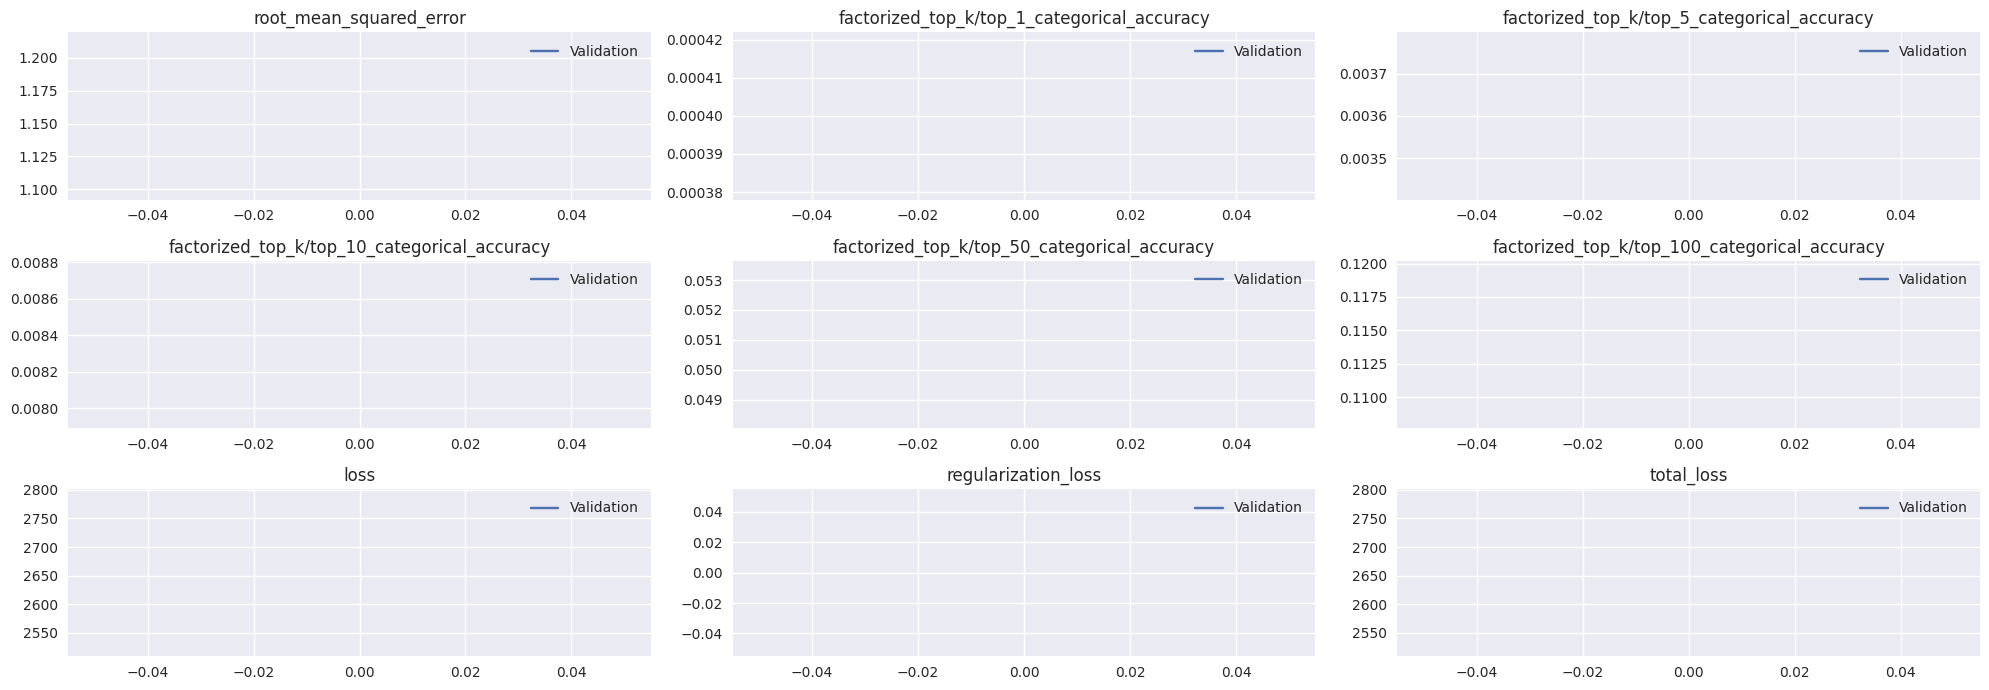

In [198]:
plot_history(history = history, plot_training=False)

In [199]:
TOP_K: int = 10

scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    model.query_tower,
    k = TOP_K,
)

scann_layer.index_from_dataset(
    candidates = tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          movies_dataset.batch(100).map(model.candidate_tower)
      )
  )
)

2024-09-06 21:10:37.956471: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-09-06 21:10:37.961500: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 4.96415ms.


In [211]:
TOP_K: int = 10

brute_layer = tfrs.layers.factorized_top_k.BruteForce(
    model.query_tower,
    k = TOP_K,
)

brute_layer.index_from_dataset(
    candidates = tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          movies_dataset.batch(100).map(model.candidate_tower)
      )
  )
)

In [201]:
user = users_dataset.take(1).as_numpy_iterator().next()
user_tensor = {k: tf.convert_to_tensor([v]) for k, v in user.items()}

top_movies = scann_layer(user_tensor, 10)
_, movie_ids = top_movies

for movie_id in movie_ids[0]:
    
    movie = movies_df.loc[movies_df['movie_id'] == movie_id]

    movie_tensor = {k: tf.convert_to_tensor([v]) for k, v in movie.items()}

    pred = model({**movie_tensor, **user_tensor})

    print(f"Movie {movie_id}: {pred[0][0]}")

Movie b'605': 4.241678714752197
Movie b'434': 4.230830192565918
Movie b'835': 4.500009536743164
Movie b'614': 4.4116363525390625
Movie b'644': 4.189601421356201
Movie b'495': 4.144431114196777
Movie b'1397': 4.056578159332275
Movie b'511': 4.04133415222168
Movie b'1078': 4.194092750549316
Movie b'144': 3.956281900405884


In [213]:

user = users_dataset.take(1).as_numpy_iterator().next()
user_tensor = {k: tf.convert_to_tensor([v]) for k, v in user.items()}

top_movies = brute_layer(user_tensor, k=10)
_, movie_ids = top_movies

for movie_id in movie_ids[0]:
    
    movie = movies_df.loc[movies_df['movie_id'] == movie_id]

    movie_tensor = {k: tf.convert_to_tensor([v]) for k, v in movie.items()}

    pred = model({**movie_tensor, **user_tensor})

    print(f"Movie {movie_id}: {pred[0][0]}")

Movie b'614': 4.4116363525390625
Movie b'835': 4.500009536743164
Movie b'605': 4.241678714752197
Movie b'434': 4.230830192565918
Movie b'644': 4.189601421356201
Movie b'495': 4.144431114196777
Movie b'144': 3.956281900405884
Movie b'1078': 4.194092750549316
Movie b'511': 4.04133415222168
Movie b'168': 4.340670108795166


## Export the Model

In [403]:
class TopK(tf.Module):

    def __init__(self, model: tfrs.layers.factorized_top_k.TopK):
        self.model = model


    @tf.function(
        input_signature = [
            {
                'user_id':               tf.TensorSpec(shape=(1,), dtype=tf.string,  name='user_id'),
                'user_gender':           tf.TensorSpec(shape=(1,), dtype=tf.int32,   name='user_gender'),
                'user_zip_code':         tf.TensorSpec(shape=(1,), dtype=tf.string,  name='user_zip_code'),
                'user_bucketized_age':   tf.TensorSpec(shape=(1,), dtype=tf.float32, name='user_bucketized_age'),
                'user_occupation_label': tf.TensorSpec(shape=(1,), dtype=tf.int32,   name='user_occupation_label'),
            },
            tf.TensorSpec(shape=None, dtype=tf.int32),
        ]
    )
    def call(self, query: Dict[str, tf.Tensor], k: int) -> Tuple[tf.Tensor, tf.Tensor]:
        """
            Call the model

            Parameters:
                - query (Dict[str, tf.Tensor]): Dictionary of input Tensors.
                - k (int): Number of predictions to return.

            Returns:
                (Tuple[tf.Tensor, tf.Tensor]): Tuple of identifiers and affinity scores.
        """
        affinities, identifiers = self.model(query, k)
        return identifiers[0], affinities[0]

In [413]:
PATH = './checkpoints'

_scann_layer = TopK(scann_layer)
_brute_layer = TopK(brute_layer)

tf.saved_model.save(
    obj = _scann_layer,
    export_dir = os.path.join(PATH, 'scann'),
    signatures = { 'call': _scann_layer.call },
    options = tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

# Export Brute Force
tf.saved_model.save(
    obj = _brute_layer,
    export_dir = os.path.join(PATH, 'brute'),
    signatures = { 'call': _brute_layer.call },
)

INFO:tensorflow:Assets written to: ./checkpoints/brute/assets


INFO:tensorflow:Assets written to: ./checkpoints/brute/assets


In [422]:
# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load("checkpoints/scann")

# Pass a user id in, get top predicted movie titles back.
_ = loaded.signatures['call'](**user_tensor, k=2)

identifiers = list(_['output_0'].numpy())
affnities   = list(_['output_1'].numpy())

dict(zip(identifiers, affnities))

{b'605': 0.5006025, b'434': 0.38176364}